In [1]:
def add_src_and_logger(is_renkolab, save_dir):
    import sys
    from pathlib import Path
    import os
    import logging 
    src_path = Path.home() / "work" / "fco2diffusion" / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    if is_renkolab:
        DATA_PATH = '/home/jovyan/work/datapolybox/'
    else:
        DATA_PATH = '../data/training_data/'
    
    if (save_dir is not None) and (not os.path.exists(save_dir)):
        os.makedirs(save_dir)

    if save_dir is None:
        logging.basicConfig(
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    else:
        logging.basicConfig(
            filename=save_dir+'training.log',
            filemode='a',
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    return DATA_PATH, logging

is_renkolab = False
save_dir = None
DATA_PATH, logger = add_src_and_logger(is_renkolab, save_dir)

In [2]:
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.models import MLP, UNet2DModelWrapper
import torch
import json
from fco2models.ueval import load_model

# load model
save_path = '../models/renko/co2clim/naive_pos/'
model_path = 'e_80.pt'
model_class = UNet2DModelWrapper


model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class, training_complete=False)
print("Model loaded")

Model loaded


In [3]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df, make_monthly_split, get_segments_random, get_segments, get_context_mask, normalize_dss, get_stats_df
df = pd.read_parquet(DATA_PATH + "SOCAT_1982_2021_grouped_colloc_augm_bin.pq")
df = prep_df(df, bound=True)[0]
#map expocode column to int
expocode_map = df['expocode'].unique()
expocode_map = {expocode: i for i, expocode in enumerate(expocode_map)}
df['expocode_id'] = df['expocode'].map(expocode_map ) 
print(df.columns)

2025-05-16 17:51:35,874 - INFO - salinity stacking
2025-05-16 17:51:35,914 - INFO - adding positional and temporal encodings
2025-05-16 17:51:37,418 - INFO - add climatology data
2025-05-16 17:51:50,958 - INFO - removing xco2 levels from fco2rec_uatm
2025-05-16 17:51:50,999 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


Index(['index', 'expocode', 'window_id', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north',
       'co2_clim8d', 'xco2', 'expocode_id'],
      dtype='object')


In [4]:
expocode_map['06AQ19860928']

16

In [5]:
# print(df.fco2rec_uatm.max(), df.fco2rec_uatm.min())

mask_train, mask_val, mask_test = make_monthly_split(df)
df_train = df[df.expocode.map(mask_train)]
df_val = df[df.expocode.map(mask_val)]
df_test = df[df.expocode.map(mask_test)]
print(df_train.fco2rec_uatm.max(), df_train.fco2rec_uatm.min())


target = "fco2rec_uatm"
predictors = params["predictors"]
coords = ['expocode_id', 'window_id']
all_cols = predictors + coords
cols = [target] + all_cols

train_stats = get_stats_df(df_train, [target] + predictors)


def prep_for_eval(df, predictors, coords):
    target = "fco2rec_uatm"
    all_cols = [target] + predictors + coords
    n_coords = len(coords)
    segment_df = df.groupby("expocode").apply(
        lambda x: get_segments(x, all_cols),
        include_groups=False,
    )
    ds = np.concatenate(segment_df.values, axis=0)
    ds_input = ds[:, :-n_coords, :]  # remove expocode and window_id
    ds_index = ds[:, -n_coords:, :]
    return ds_input, ds_index


train_ds, train_index = prep_for_eval(df_train, predictors, coords)
val_ds, val_index = prep_for_eval(df_val, predictors, coords)
test_ds, test_index = prep_for_eval(df_test, predictors, coords)

print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")
train_context_mask, val_context_mask, test_context_mask = get_context_mask([train_ds, val_ds, test_ds])
train_ds = train_ds[train_context_mask]
train_index = train_index[train_context_mask]
val_ds = val_ds[val_context_mask]
val_index = val_index[val_context_mask]
test_ds = test_ds[test_context_mask]
test_index = test_index[test_context_mask]
print(f"removing context nans")
print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")

mode = params["mode"]
train_ds_norm, val_ds_norm, test_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy(), test_ds.copy()], train_stats, mode, ignore=[])

# def add_fco2_mask(ds):
#     not_nan_mask = (~np.isnan(ds[:, 0:1, :])).astype(np.float32)
#     return np.concatenate([ds, not_nan_mask], axis=1)

# train_ds = add_fco2_mask(train_ds)
# val_ds = add_fco2_mask(val_ds)
# test_ds = add_fco2_mask(test_ds)

# count nans in first column of the dataset
print(f"train_ds shape: {train_ds.shape}, val_ds shape: {val_ds.shape}, test_ds shape: {test_ds.shape}")


Splitting data into train/val/test with parameters: month_step=7, val_offset=3, leave_out_2021=False
399.96630867451955 -390.85729311489627


2025-05-16 17:51:57,654 - INFO - Means: [np.float64(-29.70872864691208), np.float64(290.7142028808594), np.float64(32.5854606628418), np.float64(0.7363382577896118), np.float64(0.05487934499979019), np.float64(38.38909912109375), np.float64(390.3531455026237), np.float64(-18.608415603637695), np.float64(0.6533978184539941), np.float64(-0.00467142718384258), np.float64(0.28610755568715396), np.float64(-0.15461167897538317), np.float64(0.07392238530922712)]
2025-05-16 17:51:57,656 - INFO - Stds: [np.float64(56.62324526132157), np.float64(9.6060791015625), np.float64(7.259397983551025), np.float64(1.9495259523391724), np.float64(0.10938407480716705), np.float64(62.68743133544922), np.float64(17.15055241582259), np.float64(45.36433410644531), np.float64(0.29741031810997937), np.float64(0.6961297086673919), np.float64(0.5546830189221394), np.float64(0.4974931809105154), np.float64(0.5775815610979009)]
2025-05-16 17:51:57,657 - INFO - Mins: [np.float64(-390.85729311489627), np.float64(271.14

train_ds shape: (61164, 13, 64), val_ds shape: (11896, 13, 64), test_ds shape: (12229, 13, 64)


2025-05-16 17:53:03,811 - INFO - Using given stats for normalization
2025-05-16 17:53:03,812 - INFO - Normalizing data using min_max normalization
2025-05-16 17:53:03,813 - INFO - Not normalizing features: []


removing context nans
train_ds shape: (49116, 13, 64), val_ds shape: (9656, 13, 64), test_ds shape: (9998, 13, 64)
train_ds shape: (49116, 13, 64), val_ds shape: (9656, 13, 64), test_ds shape: (9998, 13, 64)


In [6]:
i = 28
# samples = val_samples[i, :, :]
truth = val_ds[i, 1, :]
indices = val_index[i, 1, :]
print(f"truth: {truth}")
print(f"indices: {indices}")

truth: [272.56    272.5525  272.5404  272.525   272.4982  272.4711  272.44556
 272.43    272.41    272.3911  272.3726  272.3552  272.3376  272.3192
 272.3072  272.29083 272.285   272.27    272.25168 272.2333  272.21542
 272.19125 272.1632  272.1412  272.1272  272.07    272.07    272.1063
 272.08884 272.07    272.0424  271.99863 271.96    271.94    272.
 272.0309  271.9854  271.94238 271.89758 271.8364  271.794   271.77
 271.72998 271.7105  271.69998 271.69    271.65652 271.64423 271.62778
 271.62    271.6119  271.6096  271.60565 271.63998 271.6     271.6
 271.6069  271.6169  271.64923 271.66    271.63858 271.75    271.63
 271.6275 ]
indices: [704. 705. 706. 707. 708. 709. 710. 711. 712. 713. 714. 715. 716. 717.
 718. 719. 720. 721. 722. 723. 724. 725. 726. 727. 728. 729. 730. 731.
 732. 733. 734. 735. 736. 737. 738. 739. 740. 741. 742. 743. 744. 745.
 746. 747. 748. 749. 750. 751. 752. 753. 754. 755. 756. 757. 758. 759.
 760. 761. 762. 763. 764. 765. 766. 767.]


In [7]:
w = 1792
# val_df_pred['delta_fco2' ] = val_df_pred['fco2rec_uatm'] - val_df_pred['xco2']
(df_val[
        (df_val.expocode == '06AQ19860928') & 
        #~pd.isna(df_val.sample_0) &
        (w <= df_val.window_id ) &
        (df_val.window_id<= w + 64)
        ]
    [['window_id', 'expocode', 'fco2rec_uatm', 'xco2', 'expocode_id', 'sst_cci', 'sss_cci']]
    ).head(64)

,window_id,expocode,fco2rec_uatm,xco2,expocode_id,sst_cci,sss_cci
17164,1792,06AQ19860928,-3.476195,346.173186,16,271.419983,33.833611
17165,1793,06AQ19860928,NaN,346.173186,16,271.434998,33.833611
17166,1794,06AQ19860928,-3.313201,346.173186,16,271.445007,33.833611
17167,1795,06AQ19860928,-2.461755,346.171746,16,271.453339,33.836525
17168,1796,06AQ19860928,-5.903253,346.171746,16,271.446655,33.837982
...,...,...,...,...,...,...,...
17223,1851,06AQ19860928,NaN,346.158786,16,272.119995,33.519108
17224,1852,06AQ19860928,12.186215,346.158786,16,272.119995,33.519108
17225,1853,06AQ19860928,14.404203,346.158786,16,272.130005,33.566391
17226,1854,06AQ19860928,NaN,346.158786,16,272.144989,33.613674


In [8]:
if losses is None:
    print("No losses found, training incomplete")
else:
    train_losses = losses['train_losses']
    val_losses = losses['val_losses']
    # print epoch with minimum loss
    print("Epoch with minimum training loss: ", np.argmin(train_losses))
    print("Minimum training loss: ", np.min(train_losses))
    
    val_losses_mean = np.mean(val_losses, axis=1)
    print("Epoch with minimum validation loss: ", np.argmin(val_losses_mean))
    print("Minimum validation loss: ", np.min(val_losses_mean))

No losses found, training incomplete


In [9]:
stats = {
    "train_maxs": params["train_maxs"],
    "train_mins": params["train_mins"],
    "train_means": params["train_means"],
    "train_stds": params["train_stds"],
}

In [10]:
train_stats['maxs'], params['train_maxs']

([np.float64(399.96630867451955),
  np.float64(306.07000732421875),
  np.float64(40.00198745727539),
  np.float64(63.528045654296875),
  np.float64(1.1509000062942505),
  np.float64(3777.700439453125),
  np.float64(422.77308803094166),
  np.float64(186.73130798339844),
  np.float64(0.9999907397361901),
  np.float64(0.9999629591162655),
  np.float64(0.9999999912466907),
  np.float64(0.9999999959542999),
  np.float64(0.9999999995924552)],
 [399.9252624511719,
  305.70501708984375,
  39.56727600097656,
  62.65434646606445,
  1.1455999612808228,
  2000.1219482421875,
  420.1968078613281,
  156.28785705566406,
  1.0,
  0.9999629855155945,
  0.9907116889953613,
  0.9999995827674866,
  1.0])

In [11]:
assert np.allclose(train_stats['maxs'], params['train_maxs'], atol=1e0)
assert np.allclose(train_stats['mins'], params['train_mins'], atol=1e0)
assert np.allclose(train_stats['means'], params['train_means'], atol=1e0)
assert np.allclose(train_stats['stds'], params['train_stds'], atol=1e0)

AssertionError: 

In [12]:
n_rec = 5
n_samples=100
train_ds = train_ds[:n_samples]
train_index = train_index[:n_samples]
val_ds = val_ds[:n_samples]
val_index = val_index[:n_samples]
test_ds = test_ds[:n_samples]
test_index = test_index[:n_samples]

In [13]:
from fco2models.utraining import full_denoise
from torch.utils.data import Dataset, DataLoader
import torch

val_context = val_ds_norm[:n_samples, 1:, :]
val_context_ds = torch.from_numpy(np.repeat(val_context, n_rec, axis=0)).float()
print("context_ds shape: ", val_context_ds.shape)
val_context_loader = DataLoader(val_context_ds, batch_size=256, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    val_samples_norm = full_denoise(model, noise_scheduler, val_context_loader, jump=20)

context_ds shape:  torch.Size([500, 12, 64])
Denoising samples
Training on cuda


Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Inference: 100%|██████████| 2/2 [00:20<00:00, 10.03s/it, timestep=tensor(19)] 


In [14]:
train_context = train_ds_norm[:n_samples, 1:, :]   
train_context_ds = torch.from_numpy(np.repeat(train_context, n_rec, axis=0)).float()
print("context_ds shape: ", train_context_ds.shape)
train_context_loader = DataLoader(train_context_ds, batch_size=256, shuffle=False)

with torch.no_grad():
    # denoise the samples
    print("Denoising samples")
    train_samples_norm = full_denoise(model, noise_scheduler, train_context_loader, jump=20)

context_ds shape:  torch.Size([500, 12, 64])
Denoising samples
Training on cuda


Inference: 100%|██████████| 2/2 [00:09<00:00,  4.87s/it, timestep=tensor(19)] 


In [15]:
train_samples_norm.shape, train_ds[:, 0:1, :].shape

((500, 1, 64), (100, 1, 64))

In [16]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_samples = rescale(
    train_samples_norm.copy(), stats, params['mode'], 
    ).reshape(n_samples, n_rec, -1)
train_error_dict = get_error_stats(
    train_samples, 
    train_ds[:, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 27.5702
MAE: 24.5359
R2: -0.4298
Bias: 22.7030 ± 12.4496
Mean correlation: 0.1646 ± 0.3907


In [17]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_samples = rescale(
    val_samples_norm.copy(), stats, params['mode'], 
    ).reshape(val_samples_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_samples = val_samples.reshape(n_samples, n_rec, -1)
val_error_dict = get_error_stats(
    val_samples, 
    val_ds[:, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 32.9750
MAE: 27.2846
R2: 0.5738
Bias: 25.4943 ± 16.1318
Mean correlation: 0.2340 ± 0.4532


In [92]:
import json
# save the error statistics to a json file in a error_stats.json in in the save_path
error_stats = {
    'train_error': train_error_dict,
    'val_error': val_error_dict
}
with open(save_path+f'error_stats_{model_path}.json', 'w') as f:
    json.dump(error_stats, f, indent=4)

TypeError: Object of type float32 is not JSON serializable

In [18]:
train_samples.shape, val_samples.shape

((100, 5, 64), (100, 5, 64))

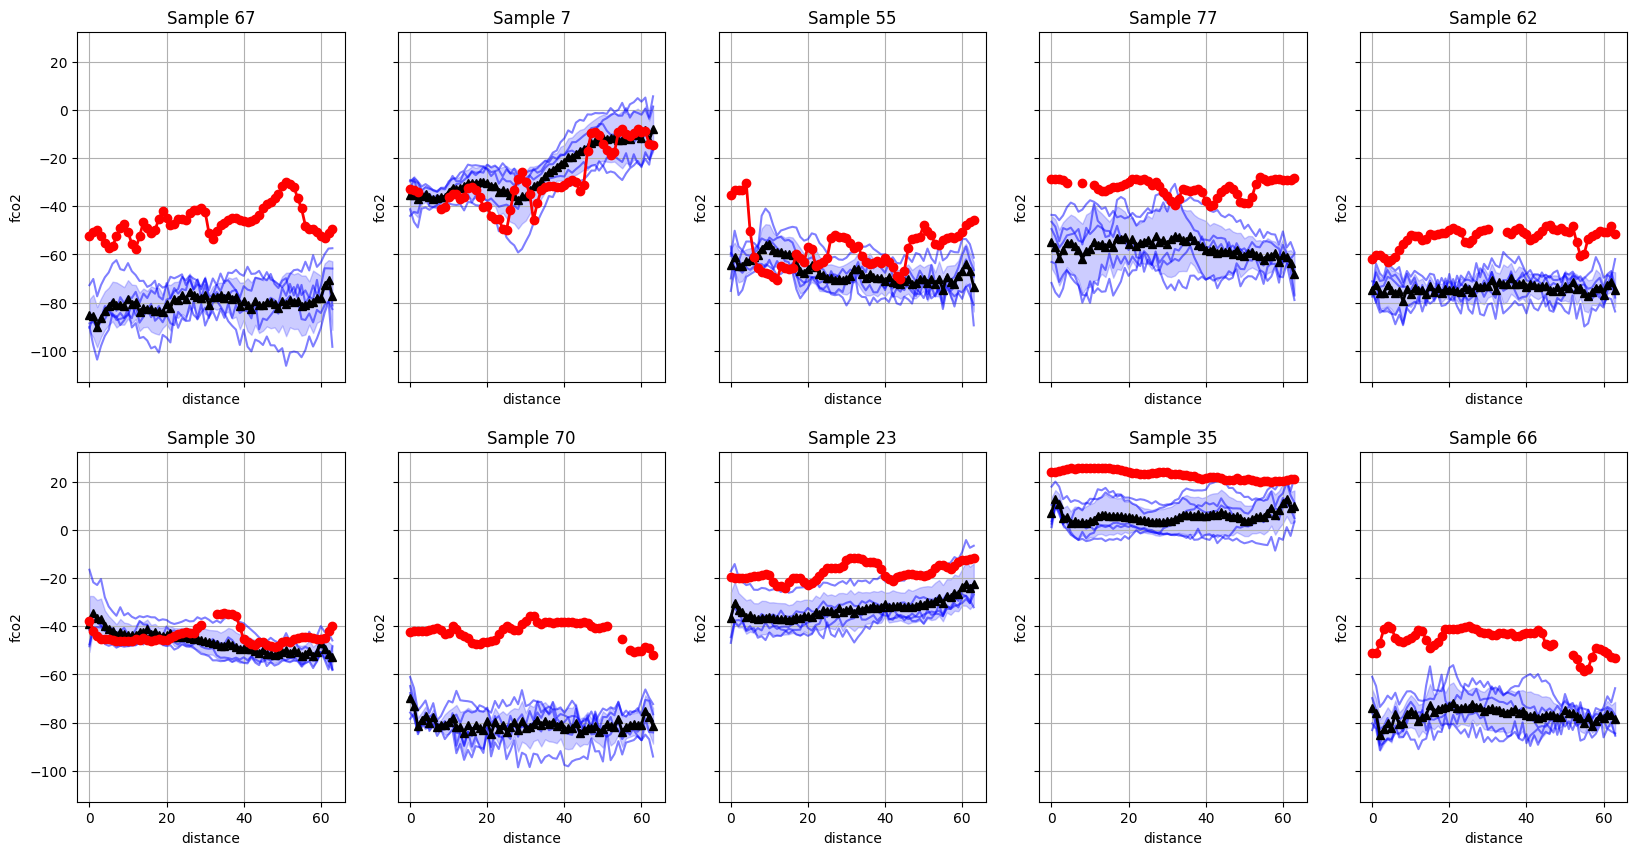

In [19]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 10, replace=False)
fig, axs = plt.subplots(len(ixs) // 5, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = train_samples[i, :, :]
    truth = train_ds[i, 0, :]
    plot_samples(ax, samples, truth, title=f"Sample {i}")

plt.show()

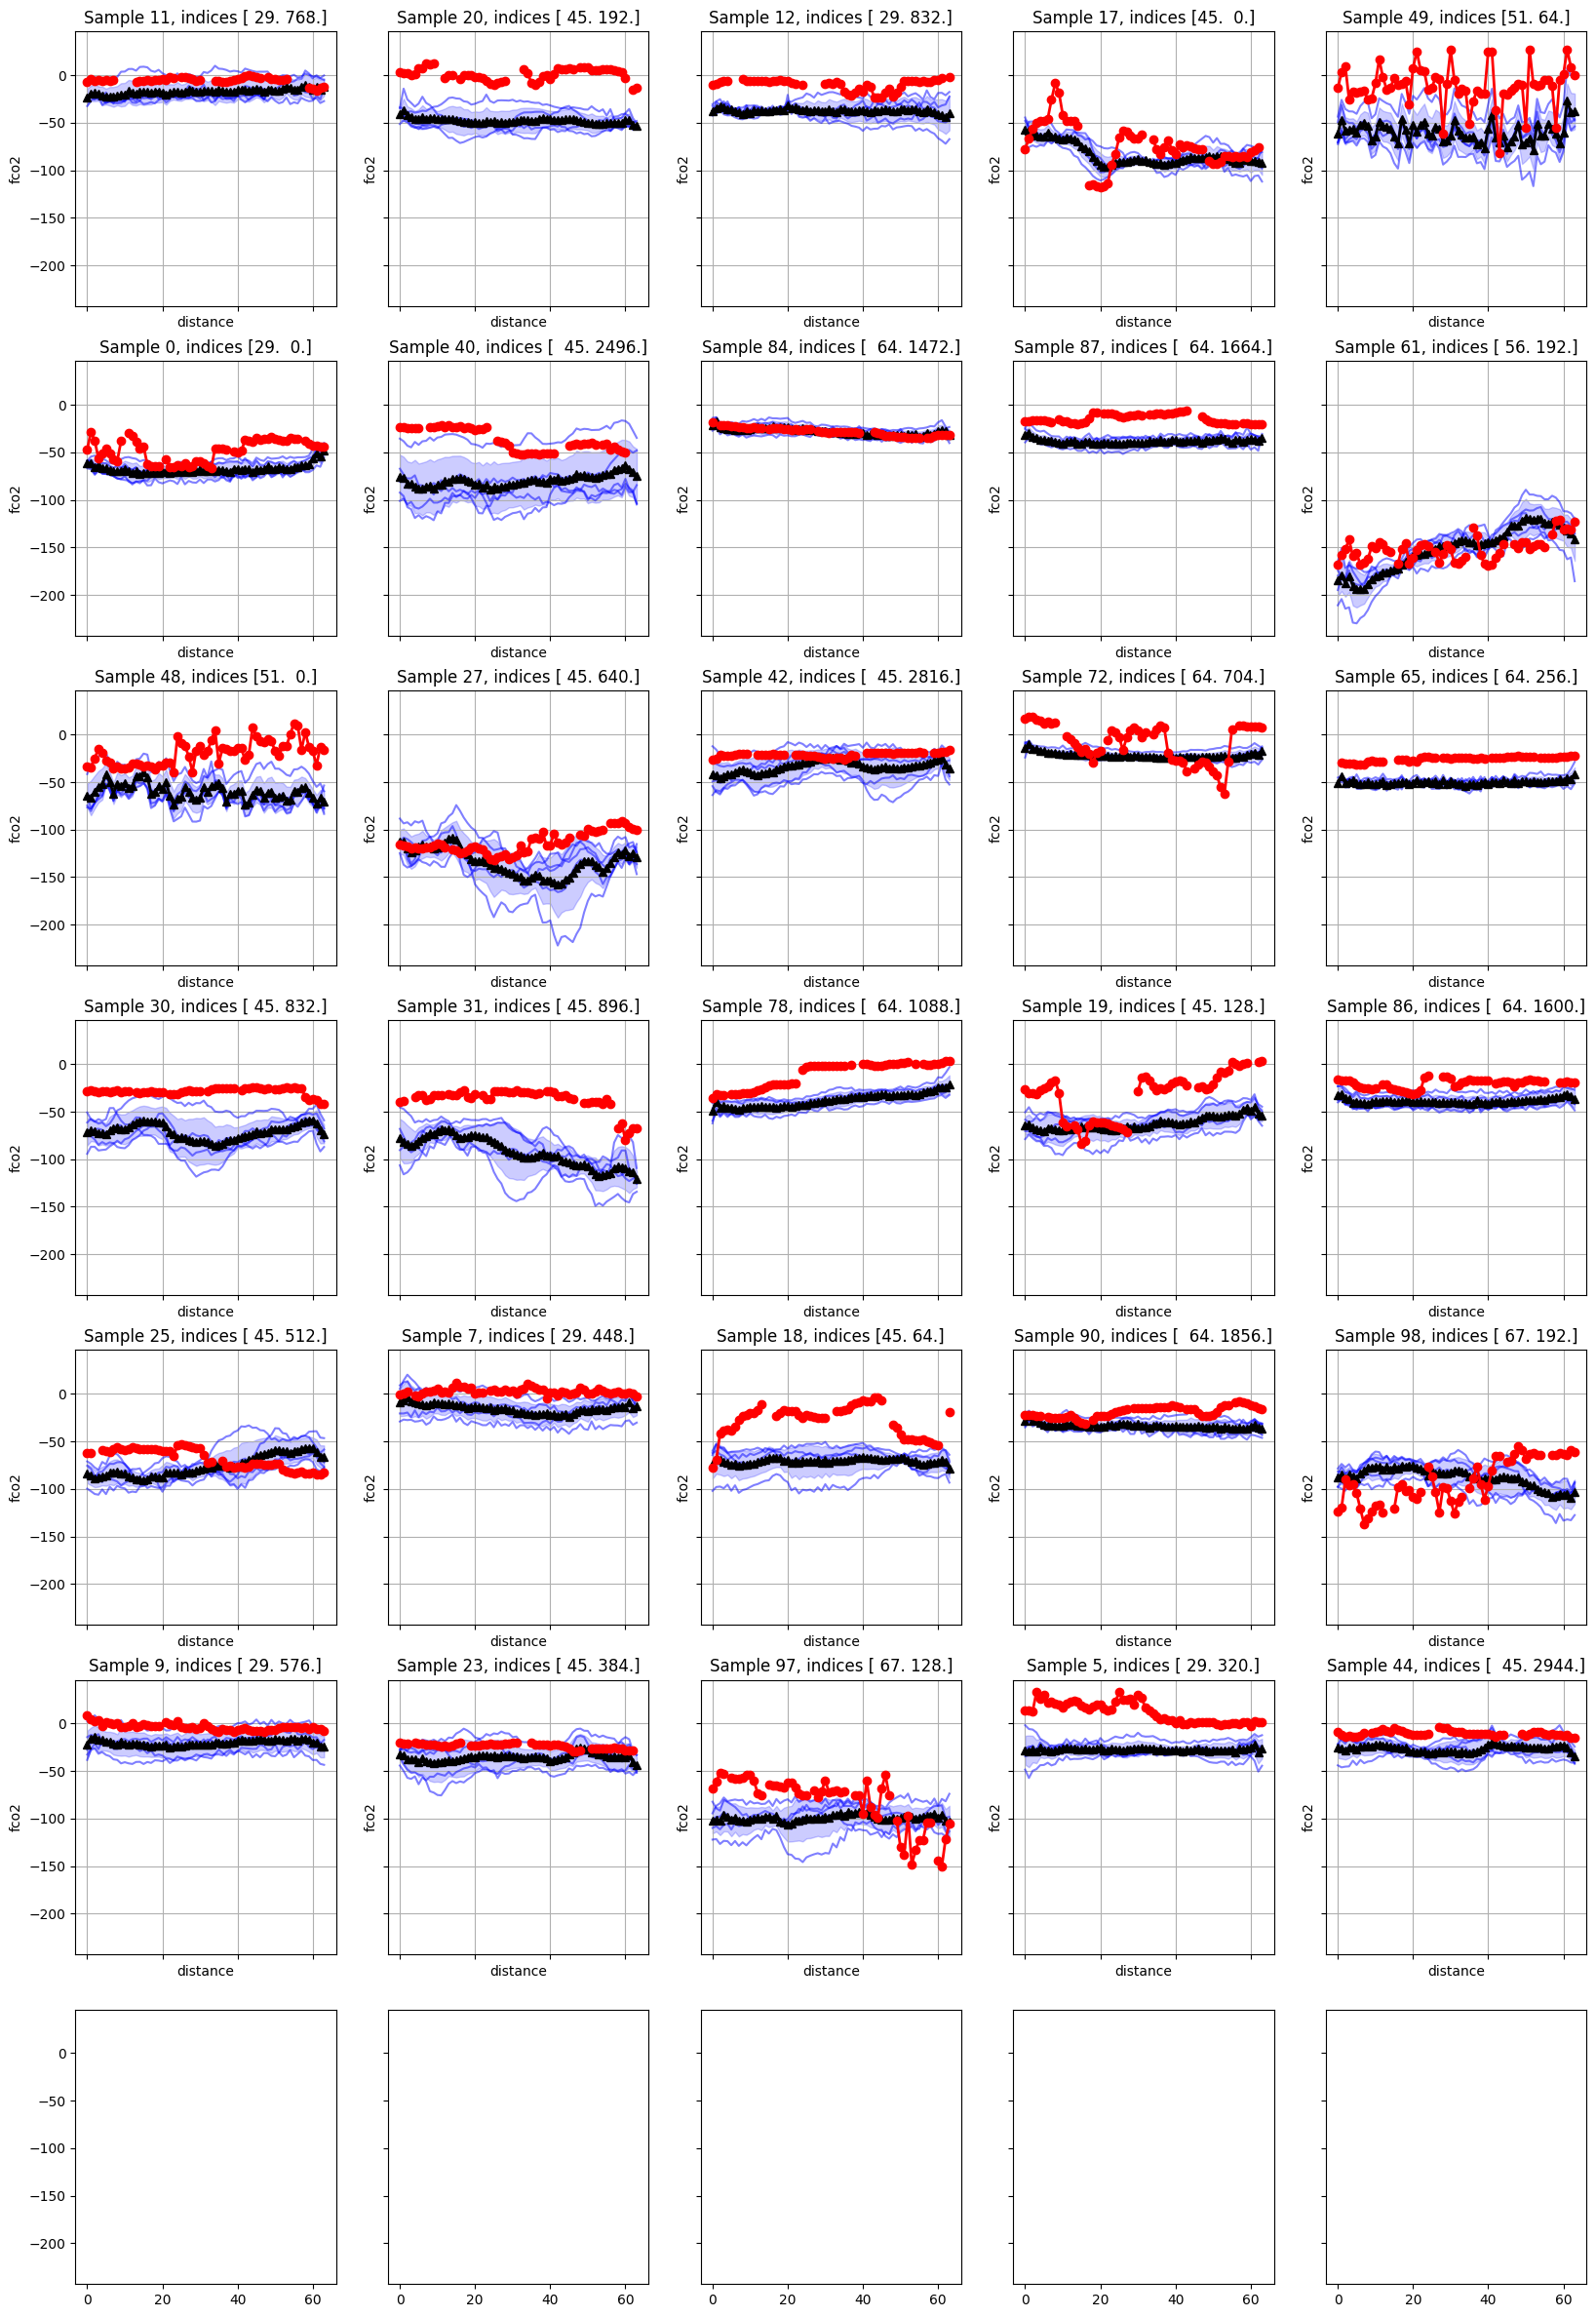

In [61]:
from fco2models.ueval import plot_samples
import matplotlib.pyplot as plt

ixs = np.random.choice(np.arange(0, n_samples), 30, replace=False)

fig, axs = plt.subplots(len(ixs)//5 + 1, 5, figsize=(20, len(ixs)), sharex=True, sharey=True)
for i, ax in zip(ixs, axs.flatten()):
    samples = val_samples[i, :, :]
    truth = val_ds[i, 0, :]
    indices = val_index[i, :, 0]
    plot_samples(ax, samples, truth, title=f"Sample {i}, indices {indices}")

plt.show()

In [21]:
i = 28
samples = val_samples[i, :, :]
truth = val_ds[i, 0, :]
indices = val_index[i, :, 0]
print("indices: ", indices)
print("sample:", samples[0])
print("truth:", truth)

indices:  [ 45. 704.]
sample: [ -98.24838   -96.58139   -96.91641   -99.48889   -98.90985  -110.036835
 -104.04401  -100.2514    -97.00122  -101.49298  -104.338715 -106.37875
 -104.31766  -107.89633  -104.2486   -104.39249   -99.85751   -98.54013
  -99.56064  -100.04535  -102.05081  -100.67465  -104.29974  -106.86386
 -105.012024 -101.934845 -102.15991  -107.3819   -113.76376  -115.961945
 -123.65967  -121.641754 -119.47775  -113.40985  -107.17337  -100.91846
  -99.10501   -92.104126  -85.403625  -84.49408   -93.4512    -97.31299
  -91.377106  -90.153595  -87.59793   -89.88342   -87.453766  -84.17703
  -88.02887   -83.33185   -89.37048   -87.23593   -94.34985   -92.88986
  -93.26471   -85.306     -82.51016   -80.15582   -80.44031   -78.5231
  -78.90268   -73.131836  -75.807465  -69.83951 ]
truth: [        nan  -98.57842   -98.7889    -99.46673   -98.14553   -99.80422
  -98.164955  -99.33222          nan  -98.64033   -94.194405  -94.104256
  -91.97962   -98.75071  -104.11695  -105.51426

In [22]:
train_samples.shape, train_index.shape

((100, 5, 64), (100, 2, 64))

In [23]:
val_samples.shape
def samples_to_df(samples, index):
    samples_index = np.concatenate((samples, index), axis=1)
    # print(samples_index.shape)
    n_samples, n_cols, n_bins = samples_index.shape
    samples_index_flat = np.full((n_samples*n_bins, n_cols), np.nan)
    for i in range(samples_index.shape[1]):
        samples_index_flat[:, i] = samples_index[:, i, :].flatten()
    df = pd.DataFrame(samples_index_flat, columns=[f"sample_{i}" for i in range(n_rec)] + ['expocode_id', 'window_id'])
    df['expocode_id'] = df['expocode_id'].astype(int)
    df['window_id'] = df['window_id'].astype(int)
    df.set_index(['expocode_id', 'window_id'], inplace=True)
    return df

train_samples_df = samples_to_df(train_samples, train_index)
val_samples_df = samples_to_df(val_samples, val_index)


In [24]:
df_train.set_index(['expocode_id', 'window_id'], inplace=True)
train_df_pred = pd.concat([df_train, train_samples_df], axis=1)
train_df_pred = train_df_pred.reset_index()
df_val.set_index(['expocode_id', 'window_id'], inplace=True)
val_df_pred = pd.concat([df_val, val_samples_df], axis=1)
val_df_pred = val_df_pred.reset_index()

In [25]:
train_df_pred.head()

,expocode_id,window_id,index,expocode,time_1d,lat,lon,sal,sst_deg_c,pppp_hpa,...,sin_lon,cos_lon,is_north,co2_clim8d,xco2,sample_0,sample_1,sample_2,sample_3,sample_4
0,0,0,0,069920180814,2018-08-15,49.806861,-2.833552,34.902527,15.872627,NaN,...,-0.049435,0.998777,True,5.848331,400.971954,NaN,NaN,NaN,NaN,NaN
1,0,1,1,069920180814,2018-08-15,49.771766,-2.854983,34.863384,15.692965,NaN,...,-0.049808,0.998759,True,5.848331,400.971954,NaN,NaN,NaN,NaN,NaN
2,0,2,2,069920180814,2018-08-15,49.730246,-2.885496,34.870758,15.744283,NaN,...,-0.050340,0.998732,True,2.747344,401.000755,NaN,NaN,NaN,NaN,NaN
3,0,3,3,069920180814,2018-08-15,49.690923,-2.921530,34.909435,15.864549,NaN,...,-0.050968,0.998700,True,2.747344,401.000755,NaN,NaN,NaN,NaN,NaN
4,0,4,4,069920180814,2018-08-15,49.652487,-2.956354,34.974567,16.029387,NaN,...,-0.051575,0.998669,True,2.747344,401.000755,NaN,NaN,NaN,NaN,NaN


In [26]:
pred_columns = [f"sample_{i}" for i in range(n_rec)]
info_df = val_df_pred

In [27]:
val_df_pred.columns

Index(['expocode_id', 'window_id', 'index', 'expocode', 'time_1d', 'lat',
       'lon', 'sal', 'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa',
       'dist_to_land_km', 'fco2rec_uatm', 'fco2rec_flag', 'time', 'year',
       'temp_soda', 'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda',
       'depth_soda', 'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci',
       'time_sstcci', 'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id',
       'segment_id', 'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm',
       'time_sshcm', 'chl_globcolour', 'chl_globcolour_uncert',
       'chl_globcolour_flags', 'time_chlgc', 'lat_chlgc', 'lon_chlgc',
       'sss_cci', 'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci',
       'time_ssscci', 'day_of_year', 'sin_day_of_year', 'cos_day_of_year',
       'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon',
       'is_north', 'co2_clim8d', 'xco2', 'sample_0', 'sample_1', 'sample_2',
       'sample_3', 'sample_4'],
      dtype='o

In [28]:
w = 1792
# val_df_pred['delta_fco2' ] = val_df_pred['fco2rec_uatm'] - val_df_pred['xco2']
(val_df_pred[
    (
        (val_df_pred.expocode == '06AQ19860928') & 
        ~pd.isna(val_df_pred.sample_0)) &
        (w <= val_df_pred.window_id ) &
        (val_df_pred.window_id<= w + 64)
        ]
    [['window_id', 'expocode', 'fco2rec_uatm', 'xco2'] + pred_columns])

,window_id,expocode,fco2rec_uatm,xco2,sample_0,sample_1,sample_2,sample_3,sample_4


In [29]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.loc[:, pred_columns].mean(axis=1)
info_df['uncert'] = info_df.loc[:, pred_columns].var(axis=1)
info_df['residuals'] = info_df['fco2rec_uatm'] - info_df['predictions']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 8).round(0) / 8.0
plotting_data = info_df.loc[:, group_cols + ['predictions', 'fco2rec_uatm', 'residuals', 'uncert']].groupby(group_cols).mean().to_xarray().coarsen(lat=10, lon=10, boundary='pad').mean()

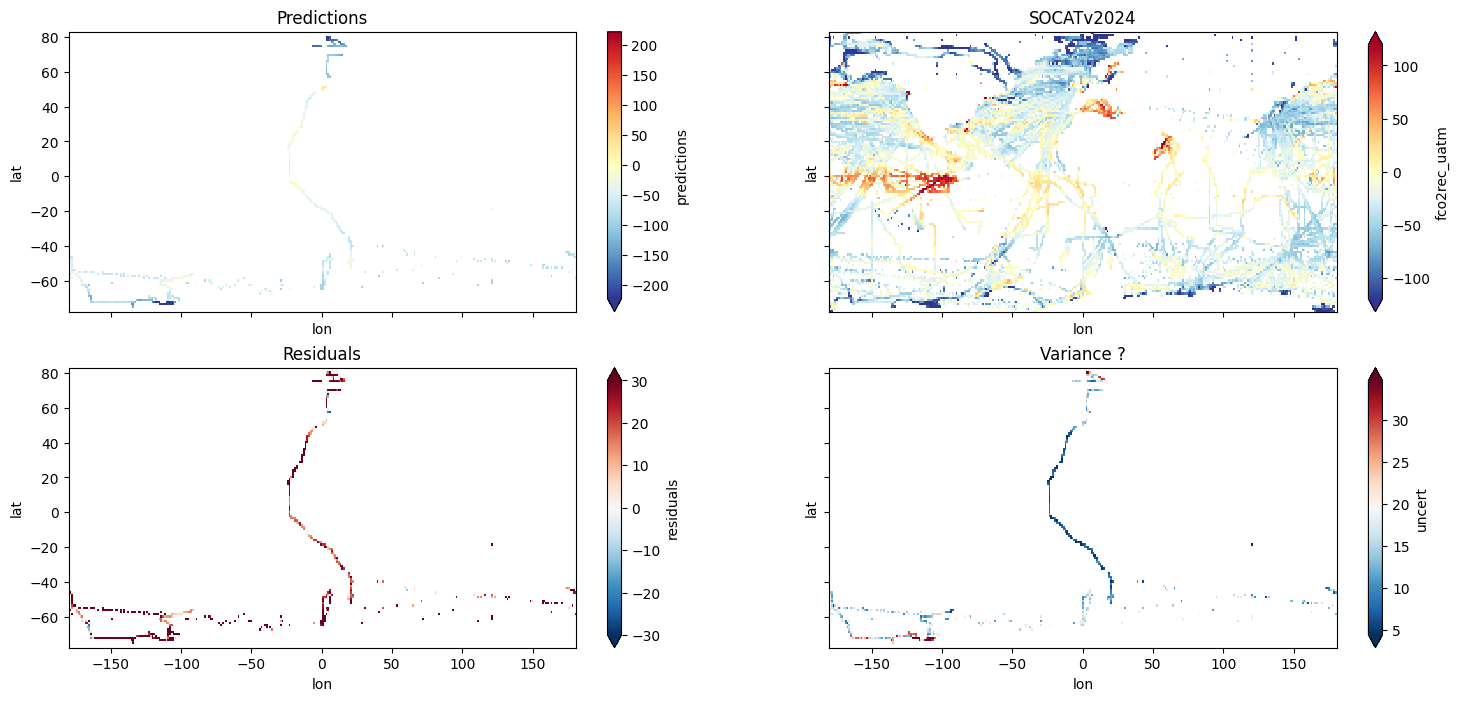

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
np.sqrt(plotting_data.uncert).plot.imshow(robust=True, ax=axs[1, 1], cmap='RdBu_r')
axs[1, 1].set_title('Variance ?')
plt.show()

In [51]:
# save the figure in the save_path
fig.savefig(save_path+f'predictions_{model_path}.png', dpi=300, bbox_inches='tight')

In [70]:
from sklearn import metrics
def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')),)
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()
    ax.set_xticks(range(0, int(y.index.max()), 64))
    

def plot_diff_samples(ax, recs, truth, **kwargs):
    windows = recs.index.get_level_values('window_id')
    recs = recs.values.T
    mean_pred = recs.mean(axis=0)
    uncert = recs.std(axis=0)
    ax.plot(windows, truth, **kwargs)
    ax.plot(windows, mean_pred, **kwargs)
    ax.fill_between(windows, mean_pred-uncert, mean_pred+uncert, alpha=0.2, color='k')


Expocode: 06AQ20141026
Expocode_id: 64


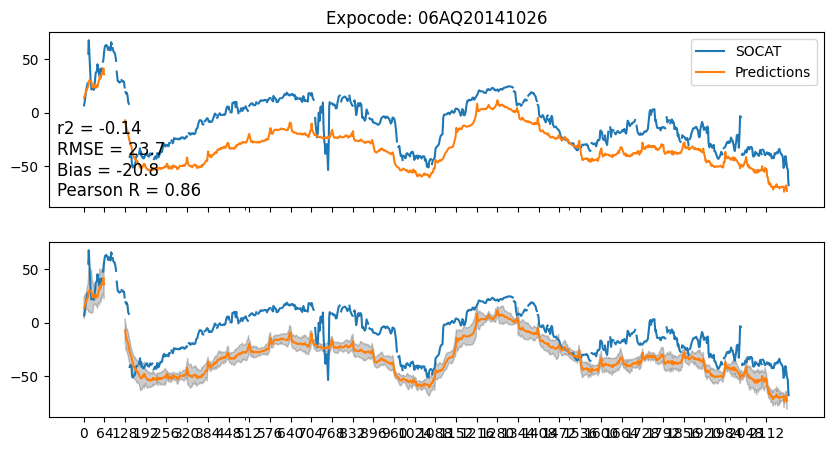

In [ ]:
# find unique expocodes in info_df
valid = info_df.groupby('expocode').apply(lambda x: x.predictions.notnull().sum() > 0,  include_groups=False)
expocodes = valid.loc[valid].index
expocode = expocodes[5]
print(f"Expocode: {expocode}")
print(f"Expocode_id: {expocode_map[expocode]}")

cruise = info_df.loc[info_df['expocode'] == expocode, pred_columns+['fco2rec_uatm', 'predictions', 'lat', 'lon', 'window_id']].groupby(['lat', 'lon']).mean()
cruise.set_index(['window_id'], inplace=True)
cruise.sort_index(inplace=True)
fig, axs = plt.subplots(2, 1, figsize=(20, 5), sharex=True, sharey=True)
plot_line_comparison(axs[0], cruise['fco2rec_uatm'], cruise['predictions'], label='Predictions')
axs[0].set_title(f"Expocode: {expocode}")
plot_diff_samples(axs[1],cruise[pred_columns], cruise['fco2rec_uatm'], label='Predictions')

In [36]:
cruise[['fco2rec_uatm', 'predictions']]

,fco2rec_uatm,predictions
window_id,,
0.0,-0.652906,NaN
2.0,-0.141752,NaN
4.5,3.504328,NaN
6.5,4.476998,NaN
8.0,5.053017,NaN
...,...,...
1189.0,-41.388561,NaN
1190.0,-40.125896,NaN
1191.5,-40.816906,NaN


# analyse baseline model

In [59]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df
val_df = pd.read_parquet('../data/training_data/valdf_100km_xco2.pq')
val_df2021 = pd.read_parquet('../data/training_data/df_100km_xco2_2021.pq')
train_df = pd.read_parquet('../data/training_data/traindf_100km_xco2.pq')

train_df, val_df, val_df2021 = prep_df([train_df, val_df, val_df2021], index=['segment', 'bin'], bound=True)

2025-05-03 19:23:50,549 - INFO - salinity stacking
2025-05-03 19:23:50,895 - INFO - adding positional and temporal encodings
2025-05-03 19:23:55,244 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:23:55,526 - INFO - add climatology data
2025-05-03 19:24:25,388 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:26,544 - INFO - salinity stacking
2025-05-03 19:24:26,576 - INFO - adding positional and temporal encodings
2025-05-03 19:24:26,958 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:26,998 - INFO - add climatology data
2025-05-03 19:24:40,822 - INFO - replacing outliers with Nans, fco2rec_uatm > 400
2025-05-03 19:24:40,955 - INFO - salinity stacking
2025-05-03 19:24:40,971 - INFO - adding positional and temporal encodings
2025-05-03 19:24:41,123 - INFO - removing atmospheric co2 levels from fco2rec_uatm
2025-05-03 19:24:41,155 - INFO - add climatology data
2025-05-03 19:24:50,666 - INFO - replacing outlier

In [60]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/baseline/naivepos/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [61]:
train_losses = losses['train_losses']
val_losses = losses['val_losses']
# print epoch with minimum loss
print("Epoch with minimum training loss: ", np.argmin(train_losses))
print("Minimum training loss: ", np.min(train_losses))

print("Epoch with minimum validation loss: ", np.argmin(val_losses))
print("Minimum validation loss: ", np.min(val_losses))

Epoch with minimum training loss:  99
Minimum training loss:  0.09788767590863781
Epoch with minimum validation loss:  36
Minimum validation loss:  0.21699580298313362


In [ ]:
from fco2models.utraining import prepare_segment_ds, normalize_dss, get_stats
predictors = params['predictors']
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
(train_ds, train_coords), (val_ds, val_coords) = prepare_segment_ds([train_df, val_df], predictors, with_mask=True, info=info)
train_stats = get_stats(train_ds)
# np.random.shuffle(val_ds)
train_ds_norm, val_ds_norm = normalize_dss([train_ds.copy(), val_ds.copy()], train_stats, params['mode'], ignore=[7, 8, 9, 10, 11, 12])
stats = {'train_means': train_stats['means'], 
         'train_stds': train_stats['stds'],
         'train_mins': train_stats['mins'], 
         'train_maxs': train_stats['maxs']
         }
# vald_ds2021 = prep_data(vald_df2021, predictors)
# val_ds = np.concatenate((val_ds, vald_ds2021), axis=0)

print("train_ds shape: ", train_ds.shape)
print("val_ds shape: ", val_ds.shape)

2025-05-03 19:24:51,142 - INFO - info features: ['lat', 'lon', 'day_of_year', 'year', 'expocode']
2025-05-03 19:24:54,564 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  209343
yX shape: (12, 209343, 64)


2025-05-03 19:25:02,047 - INFO - predictors: ['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda', 'xco2', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat', 'sin_lon_cos_lat', 'cos_lon_cos_lat']


Number of samples after filtering:  22441
yX shape: (12, 22441, 64)


2025-05-03 19:25:07,532 - INFO - Means: [np.float64(-31.85515019522005), np.float64(291.49492360826207), np.float64(32.558164963890555), np.float64(0.6836796394383253), np.float64(0.05670852774367465), np.float64(37.11385439700527), np.float64(392.4558850338762), np.float64(0.6470912102728014), np.float64(0.02198655885396615), np.float64(0.2753931007614051), np.float64(-0.16399171357166006), np.float64(0.07971597452035714), np.float64(0.8040780411812194)]
2025-05-03 19:25:07,532 - INFO - Stds: [np.float64(55.44230006579691), np.float64(9.417746927771578), np.float64(7.516368452649472), np.float64(1.8752586802383828), np.float64(0.10902147425141874), np.float64(56.17053871096368), np.float64(13.507788179586058), np.float64(0.2978493992686017), np.float64(0.7014807879549392), np.float64(0.5414473433774956), np.float64(0.4989884100091686), np.float64(0.5905557233560285), np.float64(0.3969087361993846)]
2025-05-03 19:25:07,532 - INFO - Mins: [np.float64(-391.4479064941406), np.float64(271.

train_ds shape:  (209343, 13, 64)
val_ds shape:  (22441, 13, 64)


In [63]:
assert np.allclose(train_stats['maxs'], params['train_maxs'])
assert np.allclose(train_stats['mins'], params['train_mins'])
assert np.allclose(train_stats['means'], params['train_means'])
assert np.allclose(train_stats['stds'], params['train_stds'])

In [64]:
n_samples = val_ds_norm.shape[0]

In [ ]:
def wrap_and_eval_mean_estimator(s, model, n_samples=50):
    from torch.utils.data import DataLoader, TensorDataset
    from fco2models.umeanest import predict_mean_eval
    if n_samples == None:
        n_samples = s.shape[0]
    s_context = s[:n_samples]
    print("context_ds shape: ", s_context.shape)
    s_context_ds = TensorDataset(torch.from_numpy(s_context).float())
    
    s_context_loader = DataLoader(s_context_ds, batch_size=256, shuffle=False)
    
    with torch.no_grad():
        # denoise the samples
        print("Estimating mean samples")
        losses, s_means_norm = predict_mean_eval(model, s_context_loader)
    return s_means_norm, losses
    

In [ ]:
val_means_norm, val_losses = wrap_and_eval_mean_estimator(val_ds_norm, model, n_samples=None)

context_ds shape:  (22441, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 88/88 [00:09<00:00,  9.58it/s, Loss=nan]


In [94]:
train_means_norm, train_losses = wrap_and_eval_mean_estimator(train_ds_norm, model, n_samples=None)

context_ds shape:  (209343, 13, 64)
Estimating mean samples
Predicting on cuda


Predicting: 100%|██████████| 818/818 [01:23<00:00,  9.75it/s, Loss=nan]


In [68]:
val_means_norm.shape

(22441, 1, 64)

In [95]:
from fco2models.ueval import get_error_stats, rescale
# calculate the error statistics for the validation set
print("Validation set error stats")
val_means = rescale(
    val_means_norm.copy(), stats, params['mode']
    ).reshape(val_means_norm.shape)
# val_ds_scaled = rescale(
#     val_ds.copy(), stats, params['mode']
#     ).reshape(val_ds.shape)
val_error_dict = get_error_stats(
    val_means, 
    val_ds[:n_samples, 0:1, :]
    )

Validation set error stats
Error statistics:
RMSE: 27.7383
MAE: 16.0325
R2: 0.7363
Bias: -0.2340 ± 21.1543
Mean correlation: 0.2388 ± 0.4617


In [97]:
from fco2models.ueval import get_error_stats, rescale
# get error stats for the training set
print("Training set error stats")
train_means = rescale(
    train_means_norm.copy(), stats, params['mode']
    ).reshape(train_means_norm.shape)
train_error_dict = get_error_stats(
    train_means, 
    train_ds[:, 0:1, :]
    )

Training set error stats
Error statistics:
RMSE: 17.5863
MAE: 11.2075
R2: 0.8994
Bias: -0.3116 ± 10.9017
Mean correlation: 0.3118 ± 0.4434


In [98]:
import matplotlib.pyplot as plt
def plot_preds(preds, ds, ixs, random_preds=None):
    fig, axs = plt.subplots(len(ixs), 1, sharex=True, sharey=True, figsize=(20,len(ixs) * 5))
    for (i, ix) in enumerate(ixs):
        axs[i].plot(preds[ix, 0, :].T, '^-', label='prediction', color='blue', alpha=0.5, linewidth=2)
        axs[i].plot(ds[ix, 0, :].T, 'o-', label='original', color='red', alpha=1, linewidth=2)
        if random_preds is not None:
            axs[i].plot(random_preds[ix, 0, :].T, 'o-', label='random prediction', color='green', alpha=0.5)
        axs[i].set_title(f'Prediction vs original {ix}')
        axs[i].set_xlabel('bins')
        axs[i].set_ylabel('fCO2')

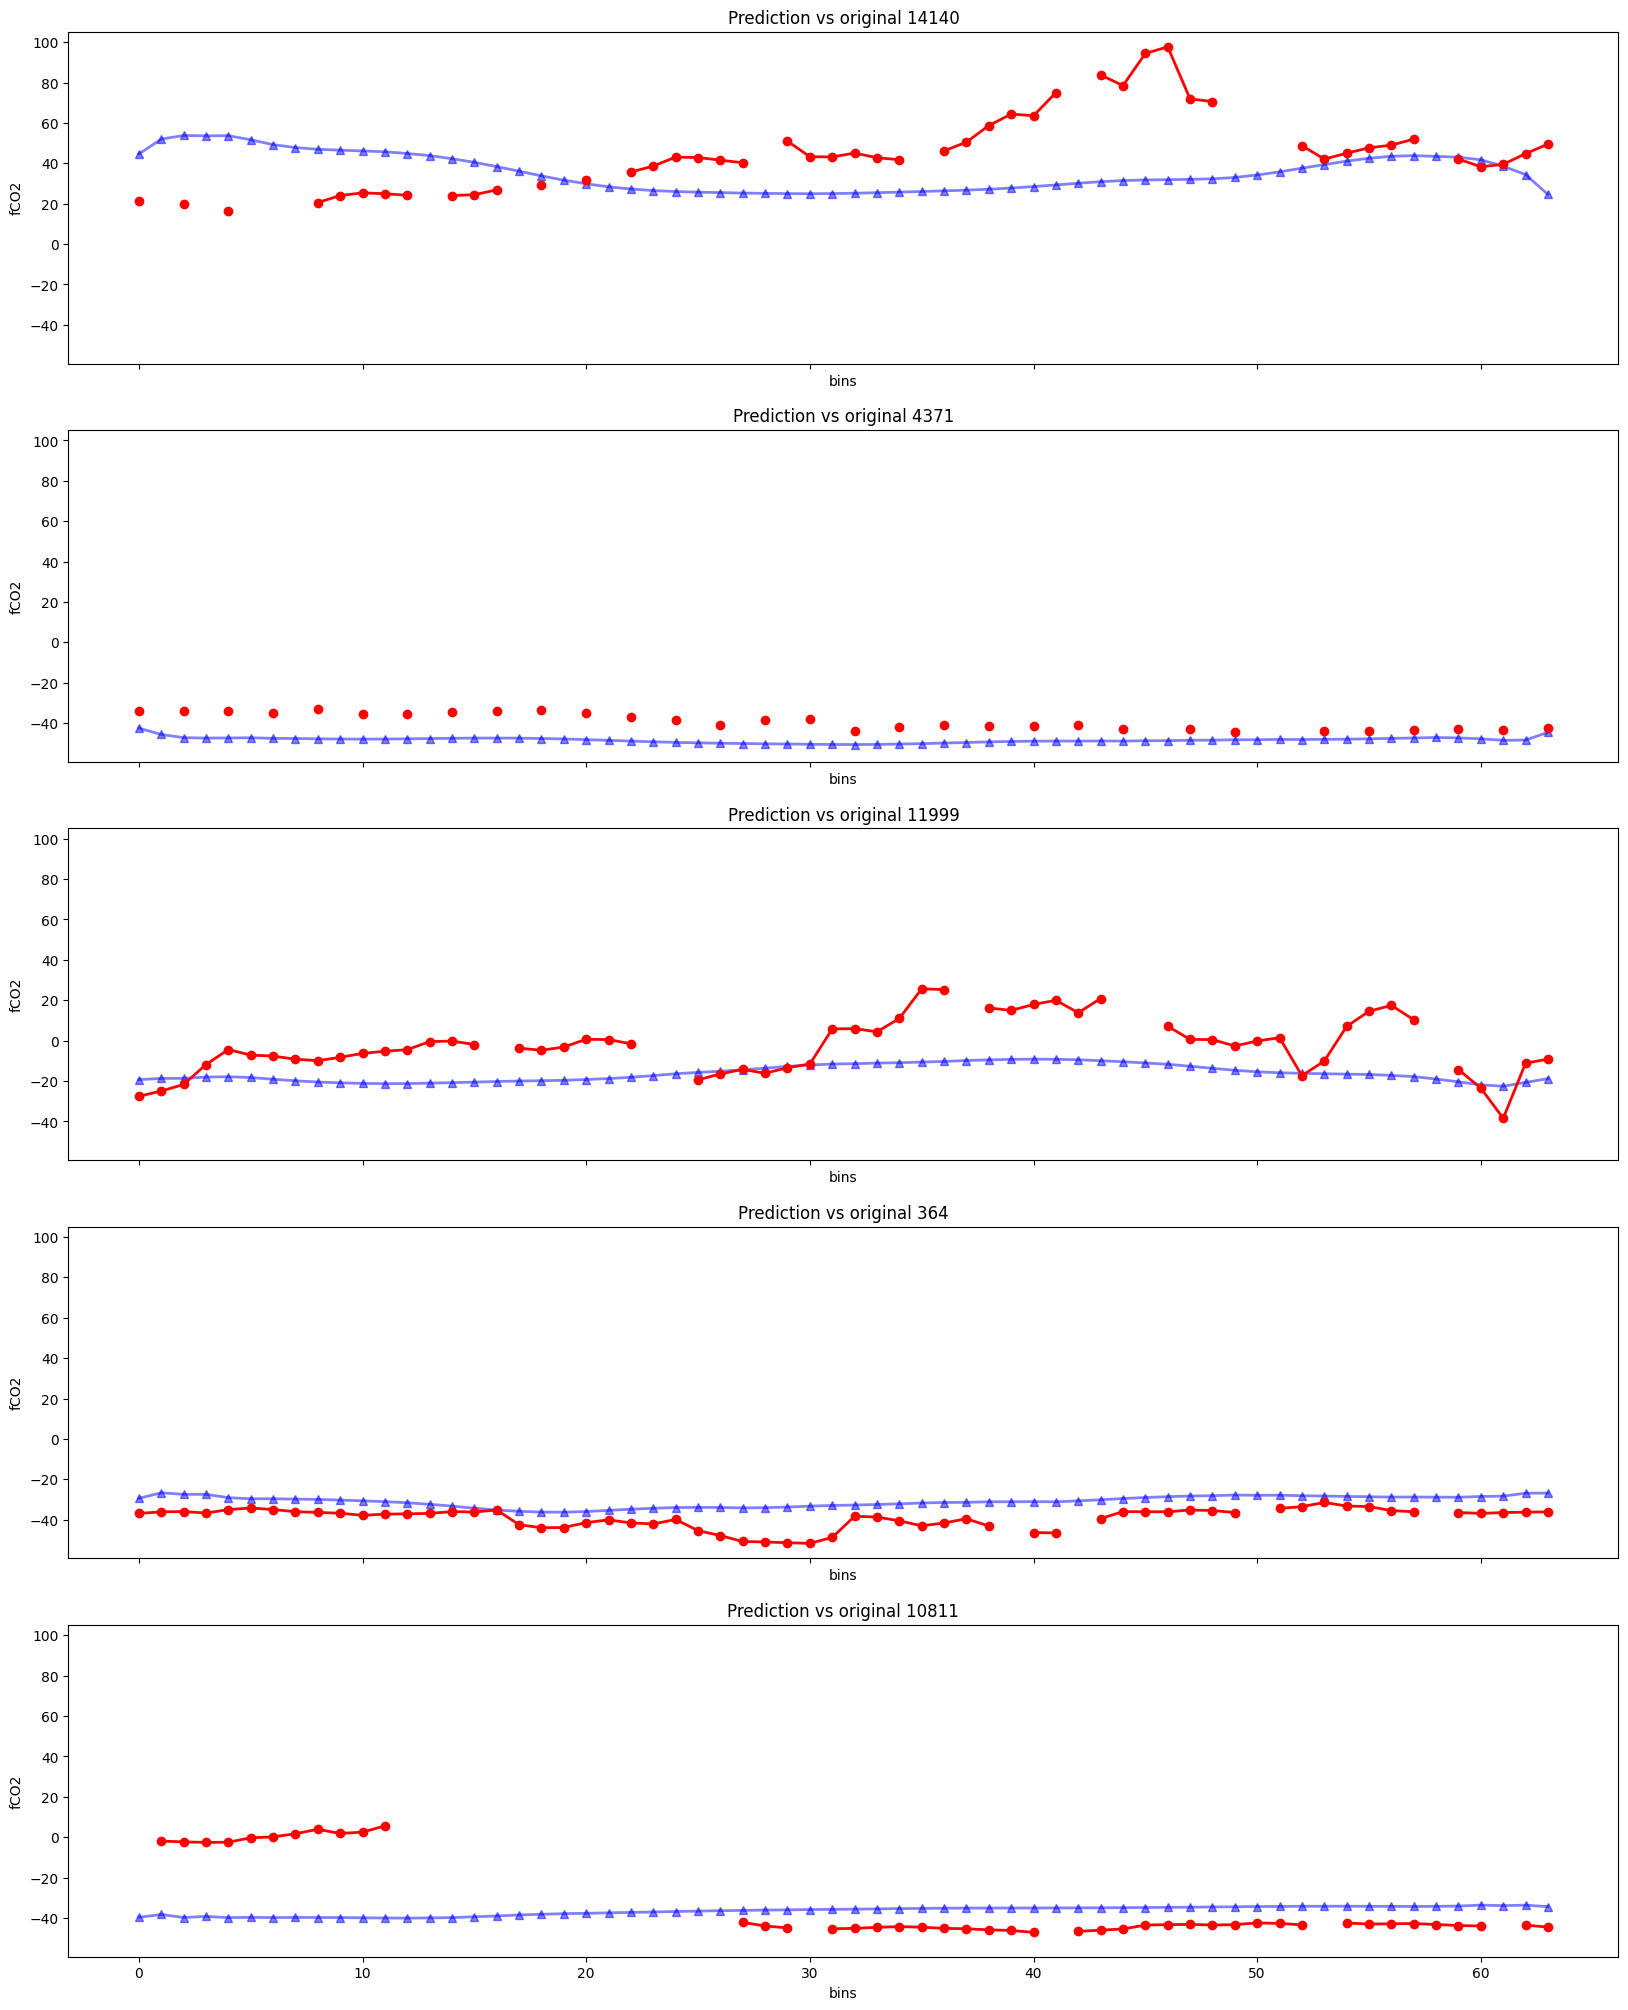

In [99]:
plot_preds(train_means, train_ds[:n_samples], np.random.choice(np.arange(n_samples), size=5, replace=False))

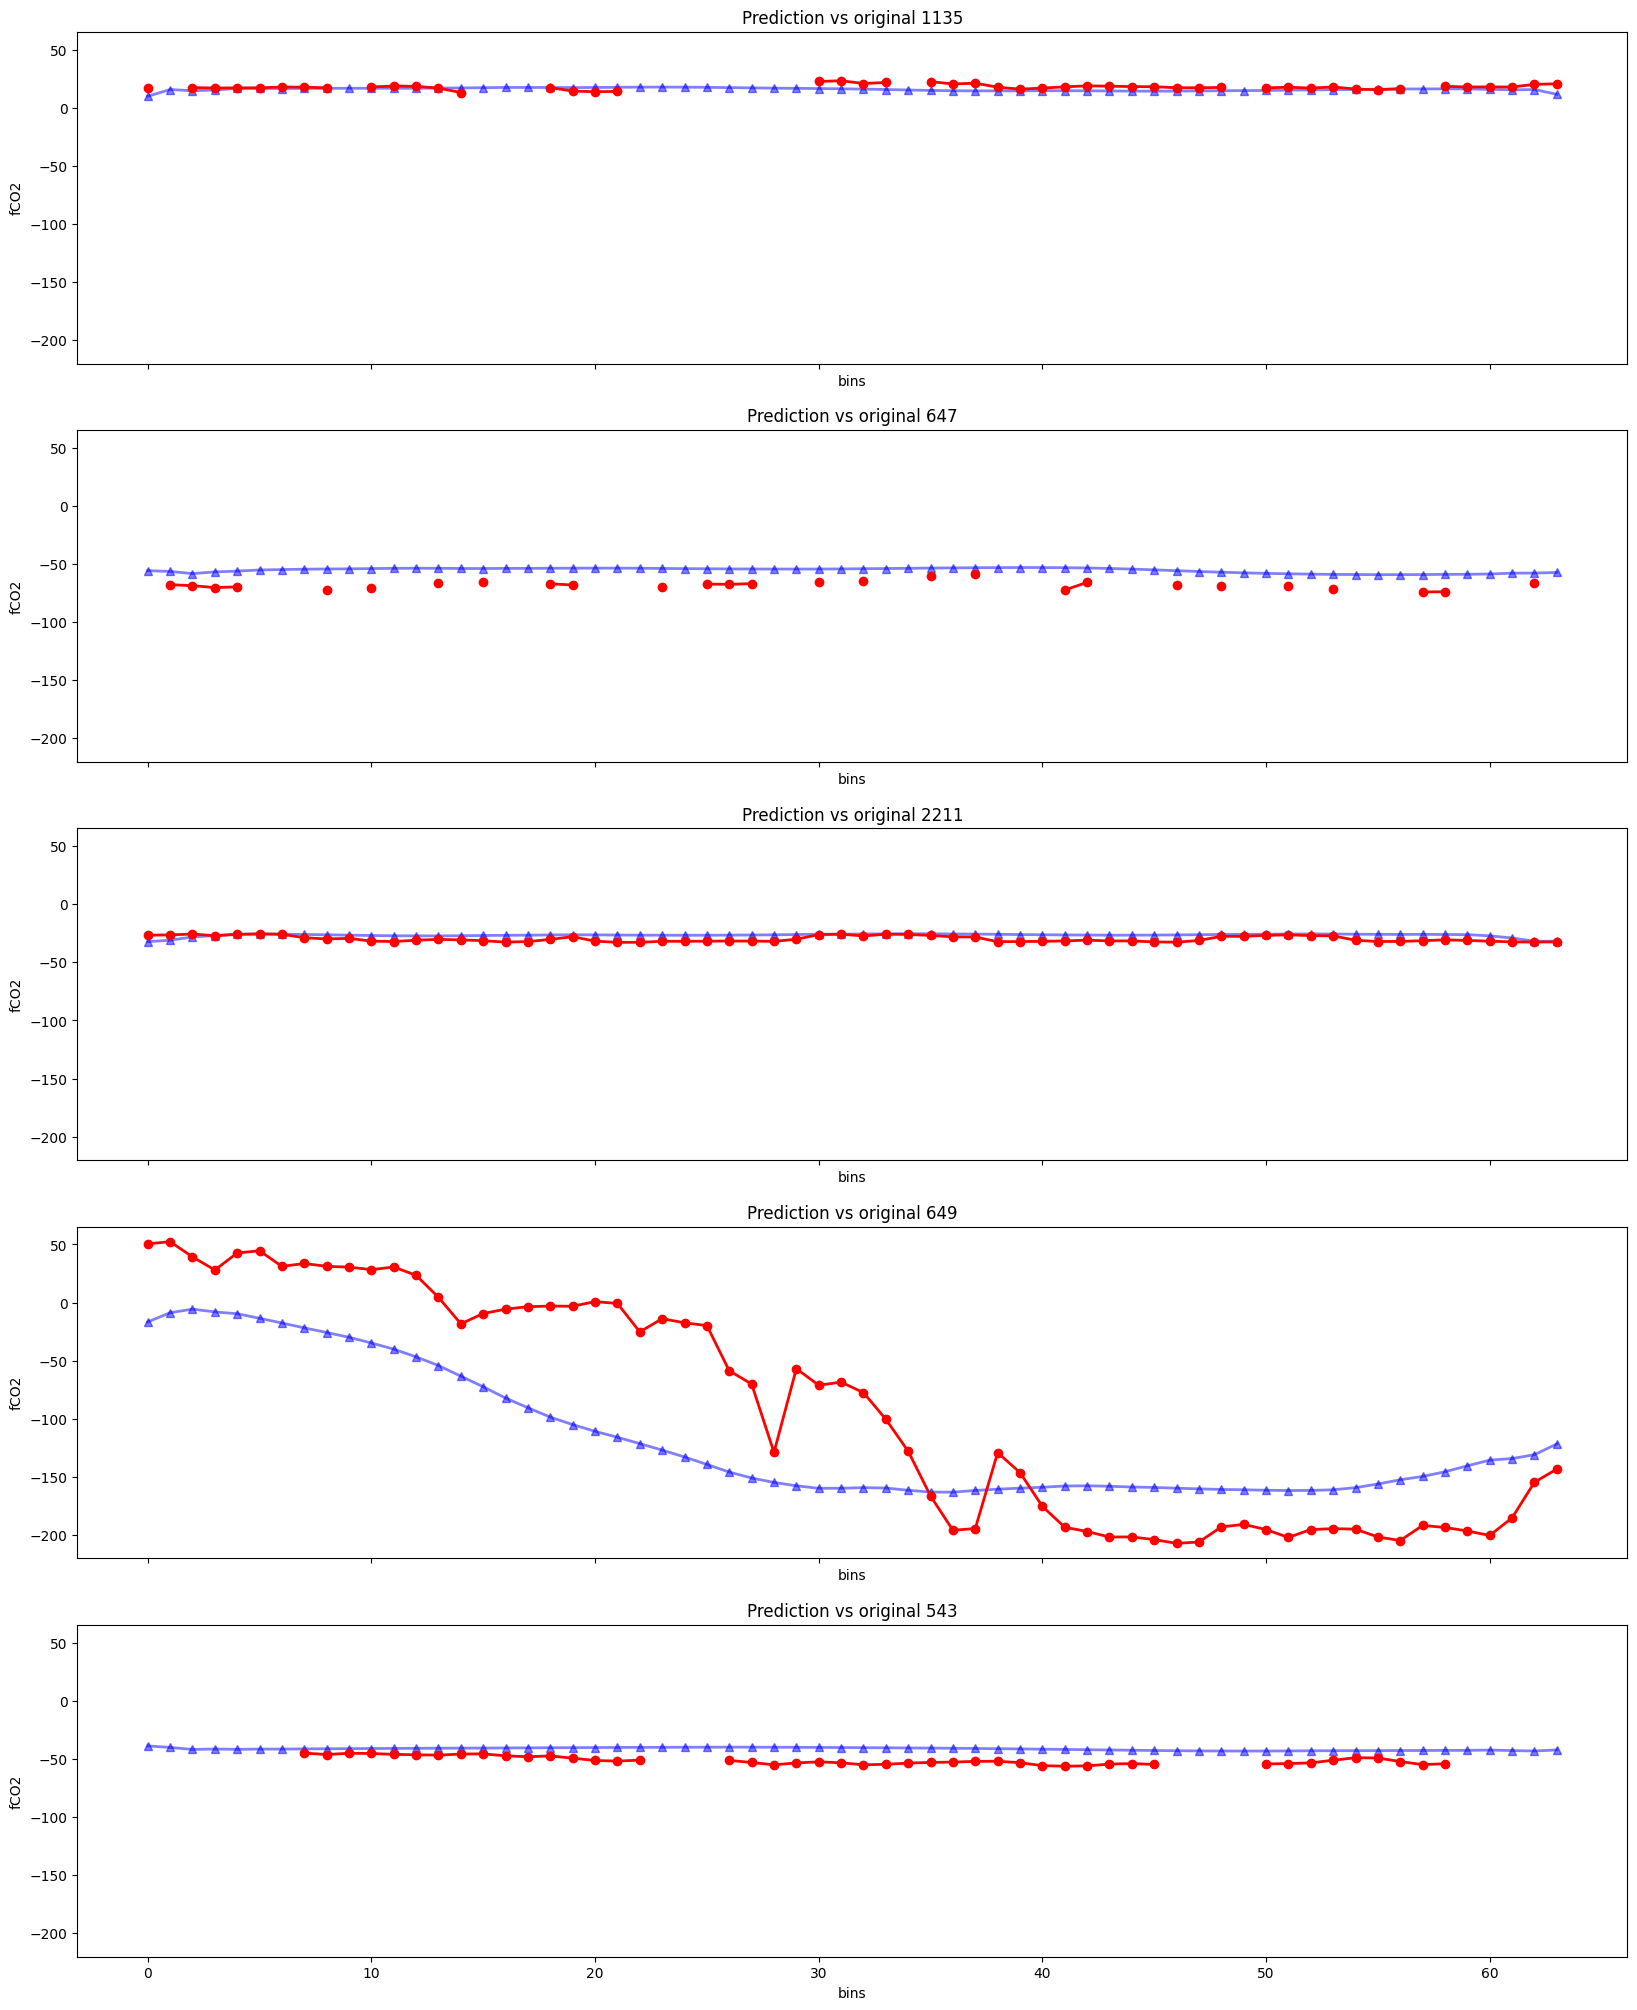

In [100]:
plot_preds(val_means, val_ds[:3000], np.random.choice(np.arange(3000), size=5, replace=False))

In [101]:
def get_info_df(preds, truth, coords, info):
    truth_preds_coords = np.concatenate((truth, preds, coords), axis=1)
    columns = ['fco2'] + [f'sample_{i}' for i in range(preds.shape[1])] + info
    truth_preds_coords_df = pd.DataFrame()
    for i, col in enumerate(columns):
        truth_preds_coords_df[col] = truth_preds_coords[:, i].flatten()
    return truth_preds_coords_df 

In [102]:
np.concatenate([val_means, train_means], axis=0).shape

(231784, 1, 64)

In [120]:
info = ['lat', 'lon', 'day_of_year', 'year', 'expocode']
info_df = get_info_df(
    np.concatenate([val_means, train_means], axis=0),
    np.concatenate([val_ds[:, 0:1, :], train_ds[:, 0:1, :]], axis=0),
    np.concatenate([val_coords, train_coords], axis=0),
    info)

In [121]:
info_df.head()

,fco2,sample_0,lat,lon,day_of_year,year,expocode
0,NaN,34.014584,10.665000,-125.195007,277.0,1997.0,430.0
1,26.631178,30.642115,10.623333,-125.206665,277.0,1997.0,430.0
2,26.800179,28.562391,10.585000,-125.220001,277.0,1997.0,430.0
3,27.555845,27.438208,10.543334,-125.236679,277.0,1997.0,430.0
4,28.614677,26.830507,10.500000,-125.250000,277.0,1997.0,430.0


In [124]:
group_cols = ['lat', 'lon']
info_df['predictions'] = info_df.iloc[:, 1]
info_df['residuals'] = info_df['predictions'] - info_df['fco2']
# round group_cols to int
info_df[group_cols] = (info_df[group_cols] * 8).round(0) / 8.0
plotting_data = info_df.loc[:, group_cols + ['predictions', 'fco2', 'residuals']].groupby(group_cols).mean().to_xarray().coarsen(lat=10, lon=10, boundary='pad').mean()

(np.float64(-180.0625),
 np.float64(180.625),
 np.float64(-78.5625),
 np.float64(82.4375))

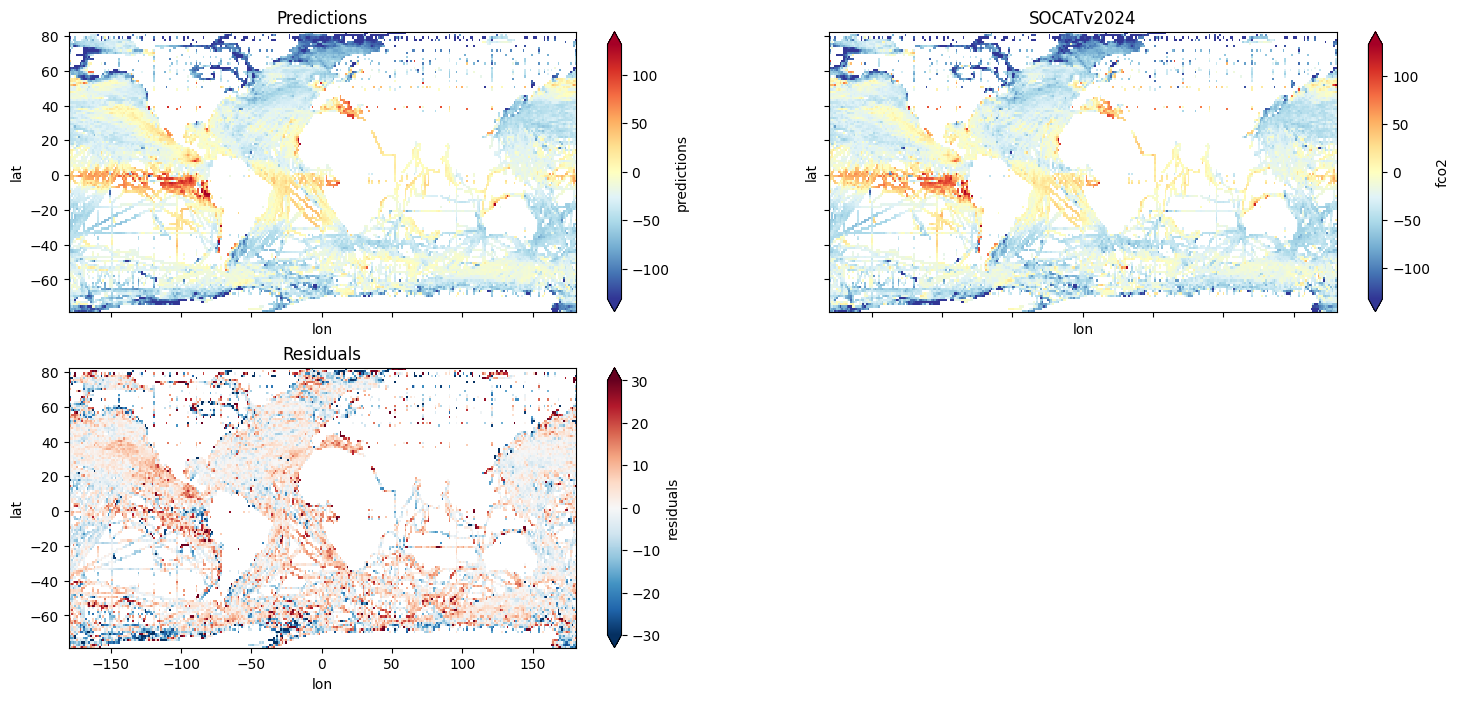

In [125]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')
axs[1, 1].axis('off')

In [ ]:
# save the figure in the save_path
fig.savefig(save_path+f'predictions_{model_path}.png', dpi=300, bbox_inches='tight')